In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from utils import *
from model import * 
from matplotlib.patches import Ellipse

In [2]:
def get_J(params): 
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    return J 

def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, 
    '''
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    B = np.diagflat([params[5]**2, gamma])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

def find_amps(params, get_J, T, n_frames, init):
    m = FHN_det(params, get_J)
    res = m.evolve(T, int(n_frames), init)
    amps = np.fft.rfft(res[:, -int(n_frames/2):], axis=-1) 
    return np.abs(amps)**2 

In [3]:
# params in the order of epsilon, gamma, mu, c 
gamma = 1
c =  14.4*gamma
mu = 0.1
epsilon = 0.374
beta = 14.25*gamma

params = [epsilon, gamma, mu, c, beta, 0.05]

T = 1e3
n_frames = int(T)
init = [1, 1]

N = 200
epsilons = np.linspace(0.0001, 0.6, N)
mus = np.linspace(0.0, 0.5, N)

In [6]:
Re = np.empty((N, N))
Im = np.empty((N, N))
Amps = np.empty((N, N))

for (i, epsilon) in enumerate(epsilons): 
    for (j, mu) in enumerate(mus):
        J = get_J([epsilon, gamma, mu, c]) 
        eigvals = np.linalg.eigvals(J)
        Re[i, j] = np.real(np.max(eigvals))
        Im[i, j] = np.imag(np.max(eigvals))
        
        params = [epsilon, gamma, mu, c, beta]
        amps = find_amps(params, get_J, T, n_frames, init)
        Amps[i, j] = np.sum(amps[1:])/n_frames 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 154, in fun
    return self.fun_single(t, y)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 23, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


In [74]:
np.save('Data/param_sweep_amps.npy', Amps)
np.save('Data/param_sweep_epsilons.npy', epsilons)
np.save('Data/param_sweep_mus.npy', mus)

In [4]:
epsilon_map = 0.374
epsilon_frac_err = 0.01/epsilon_map 

mu_map = 0.1
mu_frac_err = 0.05

centre = [mu_map, epsilon_map]
width = mu_frac_err*mu_map 
height = epsilon_frac_err*epsilon_map

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

# plot the amplitudes of oscillation 
plt.contourf(mus, epsilons, Amps, [0, 1, 5, 10, 20, 50], vmin=0, vmax=30, cmap='Greys')
plt.colorbar() 

# plot the contour of the Re eigenvalues 
cs = plt.contour(mus, epsilons, Re, levels=[-0.2, 0, 1], colors='sienna')
fmt = lambda x: r'Re= {}'.format(x)
plt.clabel(cs, inline=True, fmt=fmt, fontsize=10)

# plot the contour of the Im eigenvalues 
cs = plt.contour(mus, epsilons, Im, levels=[0, 0.2], colors='orange', alpha=0.5, linestyles='--')
fmt = lambda x: r'Im={}'.format(x)
plt.clabel(cs, inline=True, fmt=fmt, fontsize=10)

# plot the MAP values 
plt.plot(mu_map, epsilon_map, '+', color='darkorange', markersize=10)


plt.title('Oscillation amplitude')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\epsilon$')
plt.xlim([0, 0.3])
plt.ylim([0, 0.6])
plt.tight_layout()
plt.savefig('Figures/param_sweep.pdf')
plt.show() 

NameError: name 'Amps' is not defined

In [7]:
N = 1000
gamma = 1 
ratios = np.linspace(0.1, 3, N)
c_map = 14.5 
c_traj = c_map*ratios
mu_map = 0.1 
mu_traj = mu_map/ratios**2
epsilon_map = 0.374
epsilon_traj = epsilon_map/ratios**4 




T = 1e3
n_frames = int(T)
init = [1, 1]
freqs = np.fft.rfftfreq(int(n_frames/2))*2*np.pi 

Re = np.empty((N))
Im = np.empty((N))
theta_freq = np.empty((N))
p_freq = np.empty((N))

for (i, (mu, c, epsilon)) in enumerate(zip(mu_traj, c_traj, epsilon_traj)):
    J = get_J([epsilon, gamma, mu, c]) 
    eigvals = np.linalg.eigvals(J)
    Re[i] = np.real(np.max(eigvals))
    Im[i] = np.imag(np.max(eigvals))
    
    params = [epsilon, gamma, mu, c, beta]
    amps = find_amps(params, get_J, T, n_frames, init)
    
    theta_freq[i] = freqs[np.argmax(amps[0])]
    p_freq[i] = freqs[np.argmax(amps[1])]

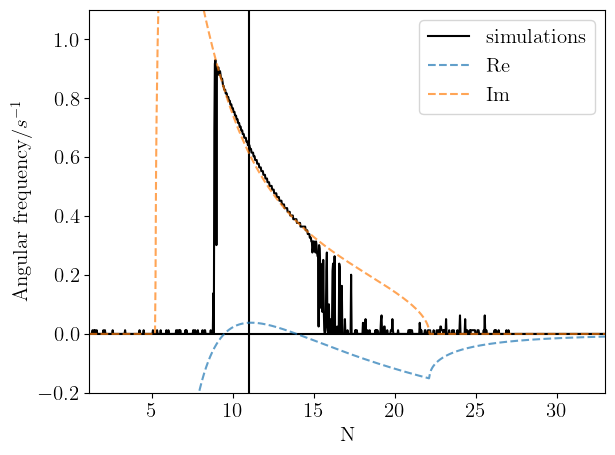

In [8]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

plt.axvline(x=11, c='k')
plt.axhline(y=0, c='k')
plt.plot(ratios*11, theta_freq, 'k', label=r'simulations')
plt.plot(ratios*11, Re, '--', alpha=0.7, label=r'Re')
plt.plot(ratios*11, Im, '--', alpha=0.7, label=r'Im')
plt.xlim([1.1, 33])
plt.ylim([-0.2, 1.1])
plt.xlabel('N')
plt.ylabel(r'Angular frequency/$s^{-1}$')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/re_im_eig.pdf')
plt.show()